In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/michal/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from datetime import datetime
from scipy.io import loadmat
from sklearn.utils import shuffle

In [3]:
def y_ohe(Y):
    ind = np.zeros((len(Y), len(set(Y))))
    for i in range(len(Y)):
        ind[i, Y[i]] = 1
    return ind

In [4]:
def error_rate(p, t):
    return np.mean(p != t)

In [13]:
def convpool(X, W, b):
    # assume pool size is 2x2 because we need to augment it with ls
    conv_out = tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    conv_act = tf.nn.relu(conv_out)
    pool_out = tf.nn.max_pool(
        conv_act, 
        ksize=[1,2,2,1], 
        strides=[1,2,2,1], 
        padding='SAME'
    )
    return pool_out

In [14]:
def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)

In [15]:
def rearrange(X):
    return (X.transpose(3, 0, 1, 2) / 255).astype(np.float32)

In [16]:
train = loadmat('./SVHN/train_32x32.mat')
test = loadmat('./SVHN/test_32x32.mat')

Xtrain = rearrange(train['X'])
Ytrain = train['y'].flatten() - 1
del train
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
Ytrain_ind = y_ohe(Ytrain)

Xtest = rearrange(test['X'])
Ytest = test['y'].flatten() - 1
del test
Ytest_ind = y_ohe(Ytest)

In [17]:
max_iter = 20
print_period = 10
N = Xtrain.shape[0]
batch_sz = 500
n_batches = N // batch_sz

In [18]:
Xtrain = Xtrain[:73000,]
Ytrain = Ytrain[:73000]
Xtest = Xtest[:26000,]
Ytest = Ytest[:26000]
Ytest_ind = Ytest_ind[:26000,]

In [19]:
M = 500
K = 10
poolsz = (2,2)

In [20]:
W1_shape = (5,5,3,20)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32)

W2_shape = (5,5,20,50)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

W3_init = np.random.randn(W2_shape[-1]*8*8, M) / np.sqrt(W2_shape[-1]*8*8 + M)
b3_init = np.zeros(M, dtype=np.float32)

W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

X = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='X')
T = tf.placeholder(tf.float32, shape=(None, K), name='T')

W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)

Z2_shape = Z2.get_shape().as_list()

# reshape(what to reshape, [what dims])
Z2r = tf.reshape(Z2, [-1, np.prod(Z2_shape[1:])])


Z3 = tf.nn.relu(tf.matmul(Z2r, W3)+b3)
Yish = tf.matmul(Z3, W4) + b4

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=T, logits=Yish))
train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

predict_op = tf.argmax(Yish, 1)

In [21]:
t0 = datetime.now()
LL = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz+batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz+batch_sz),]

            if len(Xbatch) == batch_sz:
                sess.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    test_cost = 0
                    prediction = np.zeros(len(Xtest))
                    for k in range(len(Xtest)//batch_sz):
                        Xtestbatch = Xtest[k*batch_sz:(k*batch_sz + batch_sz),]
                        Ytestbatch = Ytest_ind[k*batch_sz:(k*batch_sz + batch_sz),]
                        test_cost += sess.run(cost, feed_dict = {X: Xtestbatch, T: Ytestbatch})
                        prediction[k*batch_sz:(k*batch_sz + batch_sz)] = sess.run(predict_op, feed_dict={X: Xtestbatch})

                    err = error_rate(prediction, Ytest)
                    print('Cost/err at iteration: i={}, j={}: {:.3f}/{:.3f}'.format(i, j, test_cost, err))
                    LL.append(test_cost)
print('Elapsed time: {}'.format(datetime.now() - t0))

Cost/err at iteration: i=0, j=0: 119.522/0.924
Cost/err at iteration: i=0, j=10: 119.305/0.863
Cost/err at iteration: i=0, j=20: 118.965/0.813
Cost/err at iteration: i=0, j=30: 118.606/0.801
Cost/err at iteration: i=0, j=40: 118.250/0.801
Cost/err at iteration: i=0, j=50: 117.927/0.801
Cost/err at iteration: i=0, j=60: 117.648/0.803
Cost/err at iteration: i=0, j=70: 117.395/0.803
Cost/err at iteration: i=0, j=80: 117.177/0.804
Cost/err at iteration: i=0, j=90: 116.992/0.804
Cost/err at iteration: i=0, j=100: 116.825/0.804
Cost/err at iteration: i=0, j=110: 116.683/0.804
Cost/err at iteration: i=0, j=120: 116.558/0.804
Cost/err at iteration: i=0, j=130: 116.454/0.804
Cost/err at iteration: i=0, j=140: 116.383/0.804
Cost/err at iteration: i=1, j=0: 116.348/0.804
Cost/err at iteration: i=1, j=10: 116.295/0.804
Cost/err at iteration: i=1, j=20: 116.252/0.804
Cost/err at iteration: i=1, j=30: 116.217/0.804
Cost/err at iteration: i=1, j=40: 116.183/0.804
Cost/err at iteration: i=1, j=50: 116

Cost/err at iteration: i=11, j=70: 24.320/0.129
Cost/err at iteration: i=11, j=80: 23.504/0.125
Cost/err at iteration: i=11, j=90: 23.777/0.129
Cost/err at iteration: i=11, j=100: 23.500/0.125
Cost/err at iteration: i=11, j=110: 23.968/0.127
Cost/err at iteration: i=11, j=120: 22.879/0.122
Cost/err at iteration: i=11, j=130: 23.012/0.124
Cost/err at iteration: i=11, j=140: 23.737/0.125
Cost/err at iteration: i=12, j=0: 23.899/0.128
Cost/err at iteration: i=12, j=10: 23.472/0.126
Cost/err at iteration: i=12, j=20: 22.659/0.120
Cost/err at iteration: i=12, j=30: 23.189/0.123
Cost/err at iteration: i=12, j=40: 22.473/0.120
Cost/err at iteration: i=12, j=50: 22.735/0.121
Cost/err at iteration: i=12, j=60: 22.519/0.120
Cost/err at iteration: i=12, j=70: 22.520/0.119
Cost/err at iteration: i=12, j=80: 21.965/0.117
Cost/err at iteration: i=12, j=90: 22.627/0.122
Cost/err at iteration: i=12, j=100: 23.392/0.124
Cost/err at iteration: i=12, j=110: 23.454/0.125
Cost/err at iteration: i=12, j=120

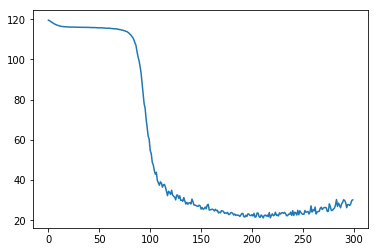

In [22]:
plt.plot(LL)
plt.show()